In [1]:
import os
import cv2
import numpy as np
import random
import torch
import matplotlib.pyplot as plt

from Models import HomographyRegressor, HomographyClassifier
from Models import classes_to_offsets, visualize_regression_result, visualize_classification_result
from Generator import generate_pair, get_random_images

In [2]:
# ============================================================
# Prepair Dataset
# ============================================================

from Generator import prepair_dataset

INPUT_DIR = "datasets/val2017"
PREPROCESSED_DIR = "datasets/val2017_preprocessed"

TARGET_SIZE = (320, 240)
# prepair_dataset(INPUT_DIR, PREPROCESSED_DIR, TARGET_SIZE)


In [3]:
from Generator import visualize_generate_pair

# Run visualization
# visualize_generate_pair(PREPROCESSED_DIR)

In [4]:
# from Models import visualize_offset_sign

# visualize_offset_sign(PREPROCESSED_DIR)

C:\Users\simon\PycharmProjects\Racunalniski-Vid\RV-N1\Models.py:519: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


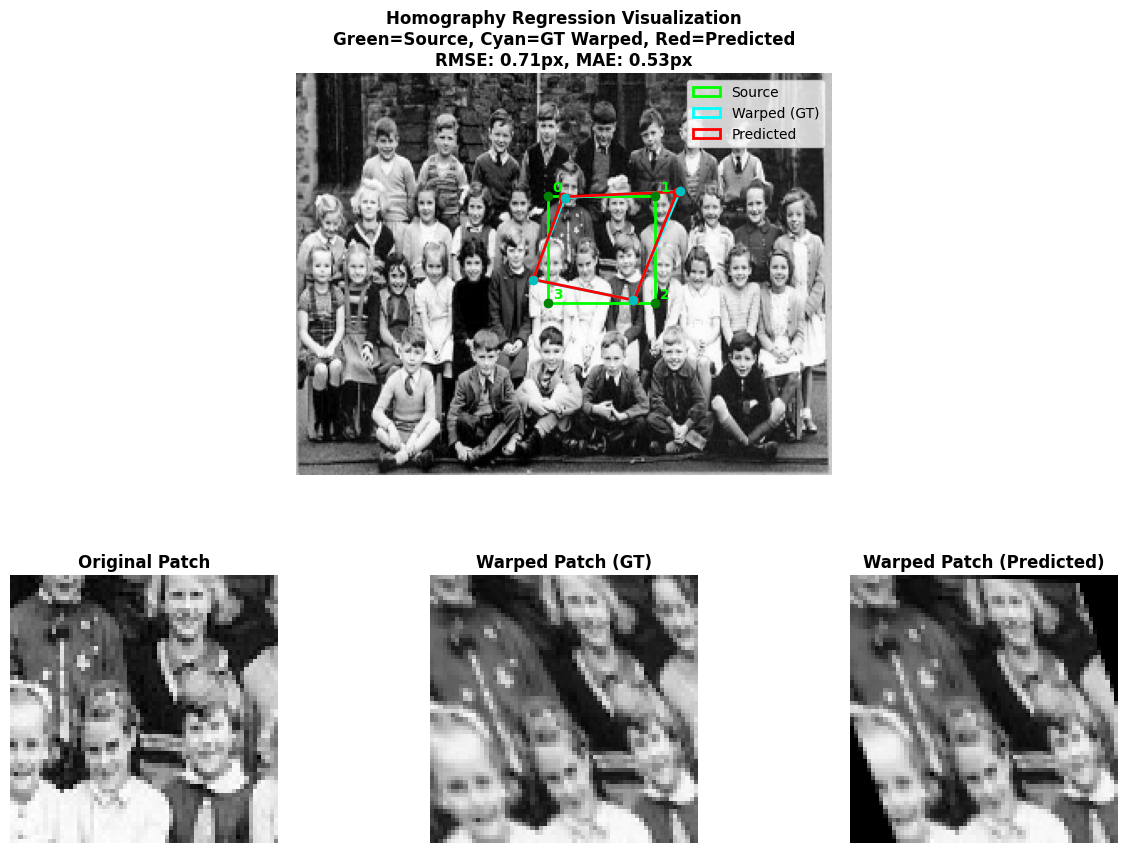

Ground Truth Offsets:
 [[ 10.   1.]
 [ 15.  -3.]
 [-13.  -2.]
 [ -9. -14.]]
Predicted Offsets:
 [[  9.22   0.5 ]
 [ 13.31  -2.59]
 [-12.7   -1.79]
 [ -8.79 -14.17]]
Mean abs error per corner: [0.743 0.319]


In [5]:
# visualization of regression results

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = HomographyRegressor().to(device)
state = torch.load("checkpoints_homography_regressor_single/checkpoint_epoch_30000.pth")["model_state_dict"]
# state = torch.load("checkpoints_homography_regressor_oneImage/h_regressor_ep50000_I1.pth")
model.load_state_dict(state)
model.eval()

img = cv2.imread("datasets/val2017_preprocessed/000000002299.jpg", cv2.IMREAD_GRAYSCALE)
# img = get_random_images(image_dir=PREPROCESSED_DIR)[0]
visualize_regression_result(model=model, image=img)

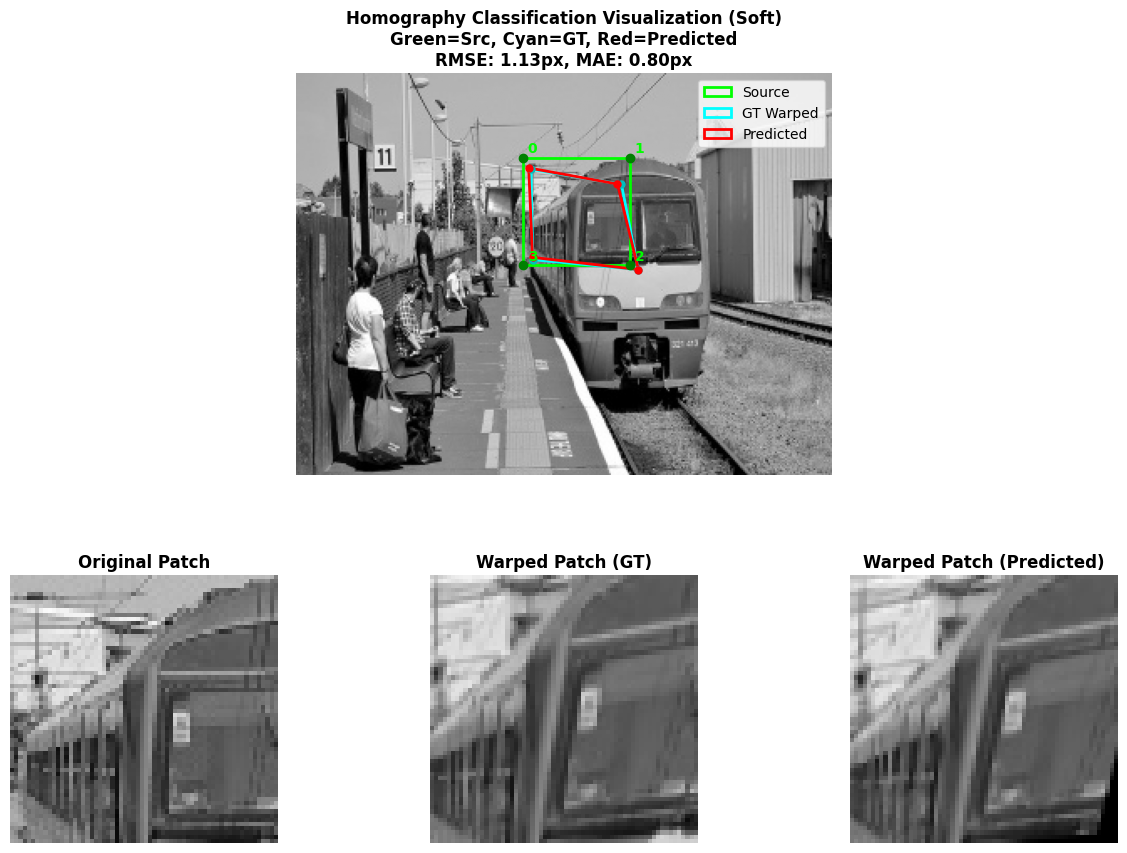

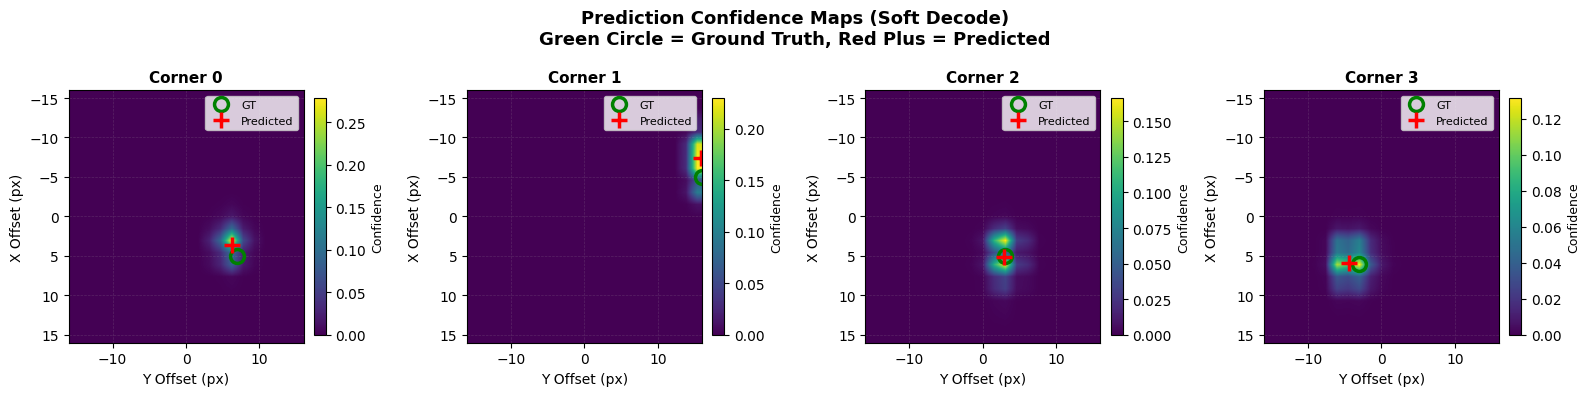

Ground Truth Offsets:
 [[ 5.  7.]
 [-5. 16.]
 [ 5.  3.]
 [ 6. -3.]]
Predicted Offsets:
 [[ 3.59  6.2 ]
 [-7.37 15.82]
 [ 5.15  2.94]
 [ 5.92 -4.36]]
Mean Abs Error per corner [px]: [1.003 0.6  ]
Overall Mean Abs Error: 0.802 px


np.float32(0.8016258)

In [11]:
# visualization of classification results

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = HomographyClassifier(num_classes=21, class_dim=8).to(device)
state = torch.load("checkpoints_homography_classify_all/checkpoint_epoch_30000.pth")["model_state_dict"]
# state = torch.load("checkpoints_homography_clasify_oneImage/h_clasify_ep50000_I1.pth")
model.load_state_dict(state)
model.eval()

# img = cv2.imread("datasets/val2017_preprocessed/000000002299.jpg", cv2.IMREAD_GRAYSCALE)
img = get_random_images(1, image_dir=PREPROCESSED_DIR)[0]
# visualize_classification_result(model=model, image=img, soft_decode=False)
# print("-"*80)
visualize_classification_result(model=model, image=img, soft_decode=True)
# visualize_classification_result_dataloader(
#     model=model,
#     dataloader=dataloader,
#     num_samples=3,
#     soft_decode=True,
#     device=device
# )

In [7]:
# from Evaluation import *
# from Generator import get_random_images
# from Models import HomographyRegressor, HomographyClassifier
# import torch
#
# images = get_random_images(100, "datasets/val2017_preprocessed")
# test_samples = generate_test_set(images, samples_per_image=10)
#
# # Compare regression models
# regressor_single = HomographyRegressor()
# regressor_single.load_state_dict(torch.load("checkpoints_homography_regressor_single/h_regressor_single.pth"))
#
# regressor_all = HomographyRegressor()
# regressor_all.load_state_dict(torch.load("checkpoints_homography_regressor_all/h_regressor_all.pth"))
#
# # results = {
# #     'Regressor (Single Image Training)': evaluate_regressor(regressor_single, test_samples),
# #     'Regressor (Full Dataset Training)': evaluate_regressor(regressor_all, test_samples)
# # }
# #
# # summarize_and_plot(results, save_dir="eval_results")
#
# # Compare classifiers (soft vs hard decoding)
# classifier = HomographyClassifier()
# classifier.load_state_dict(torch.load("checkpoints_homography_classify_all/h_classify_all.pth"))
#
# # results = {
# #     'Classifier (soft)': evaluate_classifier(classifier, test_samples, soft_decode=True),
# #     'Classifier (hard)': evaluate_classifier(classifier, test_samples, soft_decode=False)
# # }
# #
# # summarize_and_plot(results, save_dir="eval_results")
#
# # Compare classical, regressor and classifier
# results = {
#     'Classifier (Soft)': evaluate_classifier(classifier, test_samples, soft_decode=True),
#     'Regressor (All)': evaluate_regressor(regressor_all, test_samples),
#     'Classical (SIFT)': evaluate_classical(test_samples)
# }
#
# summarize_and_plot(results, save_dir="eval_results", ylim=50)


In [8]:
from Generator import get_random_images
from Models import HomographyRegressor, HomographyClassifier
from Evaluation import *
import torch

# Load images
images = get_random_images(100, "datasets/val2017_preprocessed")

# Generate test set
test_samples = generate_test_set(images, samples_per_image=10)

# Load models
regressor_all = HomographyRegressor()
regressor_all.load_state_dict(torch.load("checkpoints_homography_regressor_all/h_regressor_all.pth"))

classifier = HomographyClassifier()
classifier.load_state_dict(torch.load("checkpoints_homography_classify_all/h_classify_all.pth"))

# Visualize regression model
visualize_regression_result(regressor_all, test_samples, sample_idx=0)

# Visualize classifier model
# visualize_classifier_result(classifier, test_samples, sample_idx=0, soft_decode=True)



Generating test set: 100%|██████████| 100/100 [00:00<00:00, 139.07it/s]


TypeError: visualize_regression_result() got an unexpected keyword argument 'sample_idx'